# MovieLens 1M Data Exploratory Analysis









In [74]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

## Importing the data

### write the dat files as CSV files and create the dataframe for each file

In [3]:
dat_set = ['movies.dat', 'users.dat', 'ratings.dat']
csv_set = ['movies.csv', 'users.csv', 'ratings.csv']
name_set = [["MovieId", "Title", "Genres"], ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'],
            ['UserID', 'MovieId', 'Rating', 'Timestamp']]
df_name = ['movies', 'users', 'ratings']

for k in range(0, len(dat_set)):
    with open(dat_set[k], encoding="ISO-8859-1") as dat_file, open(csv_set[k], 'w') as csv_file:
        csv_writer = csv.writer(csv_file)

        for line in dat_file:
            row = [field.strip() for field in line.split('::')]
            csv_writer.writerow(row)

    df_name[k] = pd.read_csv(csv_set[k], names=name_set[k])

df_movies = df_name[0]
df_users = df_name[1]
df_ratings = df_name[2]

## Understanding the data

#### Let's join the ratings, users and movies dataframe and see the basic statistics of data

In [171]:
rating_movie_table = df_ratings.merge(df_movies, on='MovieId', how='left')
all_data_table = rating_movie_table.merge(df_users, on='UserID', how='left')

# Extract the debut year from the title column
def debutYear(title):
    year = title[-5:-1]
    return year

all_data_table['DebutYear'] = all_data_table['Title'].apply(lambda x: debutYear(x))

In [172]:
# Convert the epoch to human-readable dates for reference
all_data_table['Time'] = pd.to_datetime(rating_movie_table['Timestamp'], unit='s')
all_data_table['Year'] = pd.DatetimeIndex(all_data_table['Time']).year
all_data_table['Month'] = pd.DatetimeIndex(all_data_table['Time']).month

In [182]:
print(all_data_table.sort_values(['Time']).head(3))
print(all_data_table.sort_values(['Time']).tail(3))
print('Years:', all_data_table.Year.unique())
print('Months', all_data_table.Month.unique())
print('#Unique users:', all_data_table.UserID.nunique())
print('#Unique movies:', all_data_table.MovieId.nunique())
print('Unique ratings:', all_data_table.Rating.unique())

         UserID  MovieId  Rating  Timestamp                             Title  \
1000138    6040      858       4  956703932             Godfather, The (1972)   
1000153    6040     2384       4  956703954      Babe: Pig in the City (1998)   
999873     6040      593       5  956703954  Silence of the Lambs, The (1991)   

                     Genres Gender  Age  Occupation Zip-code DebutYear  \
1000138  Action|Crime|Drama      M   25           6    11106      1972   
1000153   Children's|Comedy      M   25           6    11106      1998   
999873       Drama|Thriller      M   25           6    11106      1991   

                       Time  Year  Month  
1000138 2000-04-25 23:05:32  2000      4  
1000153 2000-04-25 23:05:54  2000      4  
999873  2000-04-25 23:05:54  2000      4  
        UserID  MovieId  Rating   Timestamp                            Title  \
825724    4958     3264       4  1046454548  Buffy the Vampire Slayer (1992)   
825731    4958     2634       3  1046454548   

We can see that the MovieLens collects movie ratings of 3760 movies from 6040 users between April 2000 to Feburary 2003.

Text(0.5, 0, 'Rating Score')

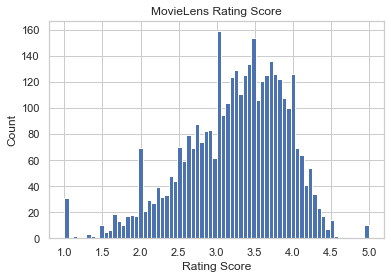

In [287]:
ratings = pd.DataFrame(all_data_table.groupby('Title')['Rating'].mean())
ratings['Rating_size'] = all_data_table.groupby('Title')['Rating'].count()
ratings['Rating'].hist(bins=70)
plt.title("MovieLens Rating Score")
plt.ylabel('Count')
plt.xlabel('Rating Score')

From the histogram of rating score above, most of the rating score ranges from 3.0 to 4.0 and the distribution is skewed to the left. Now we want to take a look of the number of rating per movie.

Text(0.5, 0, 'Number of Rating')

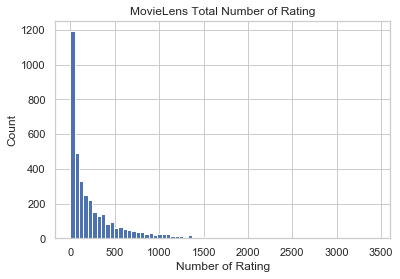

In [296]:
ratings['Rating_size'].hist(bins=70)
plt.title("MovieLens Total Number of Rating")
plt.ylabel('Count')
plt.xlabel('Number of Rating')

Most of our number of ratings are quite few and most of the movies have either one or zero rating. Now let's have a look of the pattern between rating and number of rating.

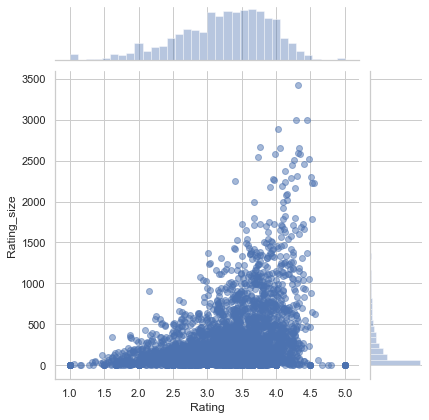

In [295]:
sns.jointplot('Rating', 'Rating_size', data=ratings, alpha=0.5)

From the jointplot, it is observed that movies which have higher rating score usually are rated more frequently. It makes sense because the classical and popular movies are viewed and rated more often and therefore are rated higher.

Now, let's see what impacts the rating score and total number of rating.

### Timing Effect Analysis

The median of movie rating is 3.33 and median of total ratings are 350. However, there are circumstances where only one person rates the movie, showing the rating score with fewer reviewer are not reliable in making prediction.

In [18]:
avg_rating = pd.DataFrame(rating_movie_table.groupby('Title')['Rating'].mean())
avg_rating['Total Ratings'] = pd.DataFrame(rating_movie_table.groupby('Title')['Rating'].count())
print(avg_rating.describe())

            Rating  Total Ratings
count  3706.000000    3706.000000
mean      3.238892     269.889099
std       0.672925     384.047838
min       1.000000       1.000000
25%       2.822705      33.000000
50%       3.331546     123.500000
75%       3.740741     350.000000
max       5.000000    3428.000000


To avoid the bias which treats the rating with one total rating the same as the rest, we filter the data to find the top 15 movies with more than 30 total rating. 30 is a good estimation because the first quartile is 33.

In [19]:
movie_stats = all_data_table.groupby('Title').agg({'Rating': [np.size, np.mean]})
atleast_30 = movie_stats['Rating']['size'] >= 30
top_15 = movie_stats[atleast_30].sort_values([('Rating', 'mean')], ascending=False)[:15]

print(top_15)

                                                   Rating          
                                                     size      mean
Title                                                              
Sanjuro (1962)                                         69  4.608696
Seven Samurai (The Magnificent Seven) (Shichini...    628  4.560510
Shawshank Redemption, The (1994)                     2227  4.554558
Godfather, The (1972)                                2223  4.524966
Close Shave, A (1995)                                 657  4.520548
Usual Suspects, The (1995)                           1783  4.517106
Schindler's List (1993)                              2304  4.510417
Wrong Trousers, The (1993)                            882  4.507937
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)         470  4.491489
Raiders of the Lost Ark (1981)                       2514  4.477725
Rear Window (1954)                                   1050  4.476190
Paths of Glory (1957)                           

Not surprisingly, the classical movies get more ratings and higher score. 
Then we want to see whether the rating score will change over time. 

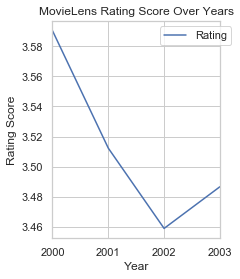

In [125]:
time_year_tats = all_data_table.groupby('Year').agg({'Rating': np.mean})
time_month_tats = all_data_table.groupby(['Year','Month']).agg({'Rating': np.mean})
time_year_tats.plot(figsize=(3,4),label=title)
plt.title("MovieLens Rating Score Over Years")
plt.ylabel('Rating Score')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.1, 1))

The average rating score goes down with time but bounces somehow in 2003. 

Now, let's have a look at the yearly and monthly rating distribution.

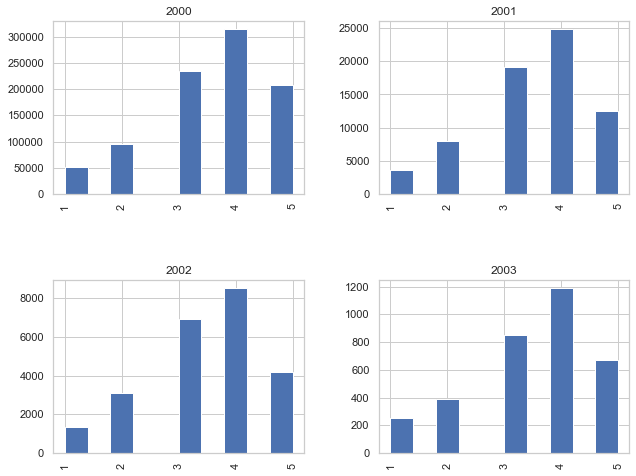

In [188]:
all_data_table['Rating'].hist(by=all_data_table['Year'], figsize=(10, 8));

We can observe similar distributions for each year. It is not hard to see that the number of people who give movie rating either 1 or 2 significantly decreases, driving the average rating up for year 2003. Then we further explore the pattern for each month.


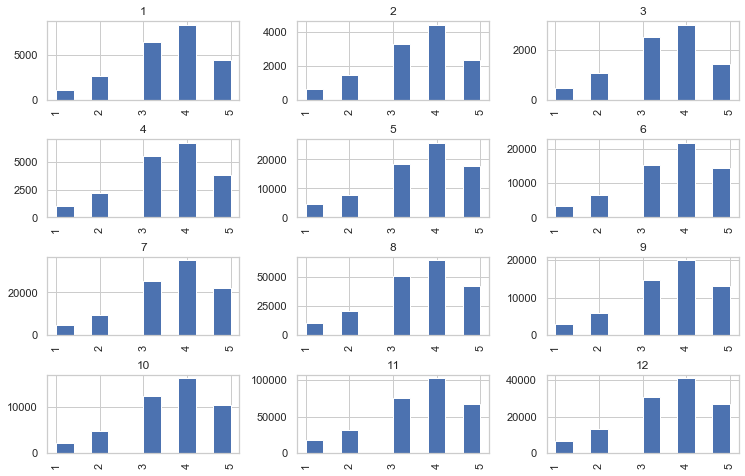

In [191]:
all_data_table['Rating'].hist(by=all_data_table['Month'], figsize=(12, 8));

Similar to the yearly performance, the individual month's average rating pattern is very close to each other.

Then will the individual movie shows pattern in its rating over the years? Let's only look at top 5 movies with highest rating score.

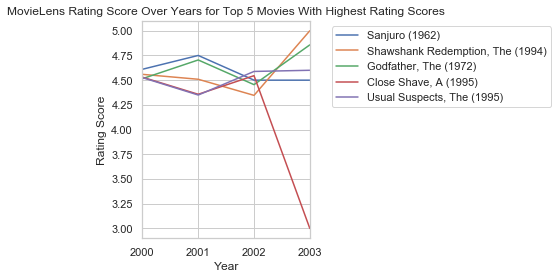

In [195]:
top_5_list = ["Sanjuro (1962)", 'Shawshank Redemption, The (1994)', 'Godfather, The (1972)', 'Close Shave, A (1995)', 
             'Usual Suspects, The (1995)']
top_5 = all_data_table[all_data_table['Title'].isin(top_5_list)].groupby(['Title', 'Year'])['Rating'].mean()

for title in top_5_list:
    top_5[title].plot(figsize=(3,4),label=title)
plt.title("MovieLens Rating Score Over Years for Top 5 Movies With Highest Rating Scores")
plt.ylabel('Rating Score')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.1, 1))

We can't say rating is changing with time because some movies' rates go up and others go down. This finding is in compliance with our previous results.

Now let's explore some pattern in the number of rating per year.

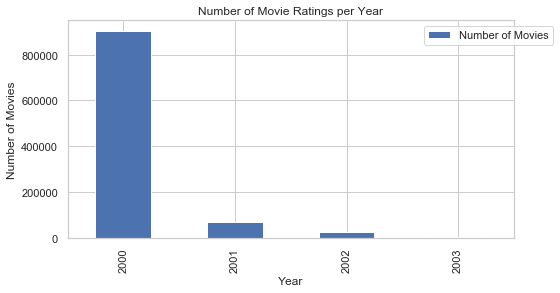

In [192]:
prod_year_stats = all_data_table.groupby('Year').size()
prod_year_stats.plot.bar(figsize=(8,4), label='Number of Movies')
plt.title("Number of Movie Ratings per Year")
plt.ylabel('Number of Movies')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.1, 1))

We can see that most number of ratings are available for the year 2000(approximately 900k, which is equivalent to around 90% of the data points). Now have a look at the monthly distribution of number of rating.

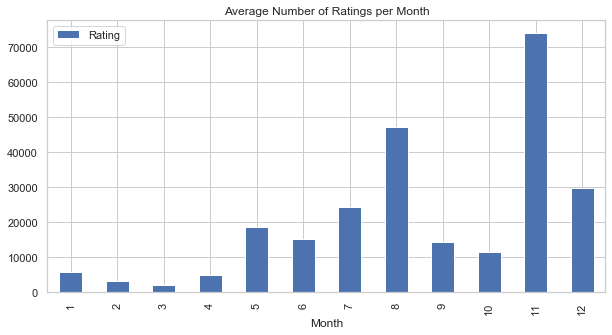

In [193]:
df_temp = all_data_table[['Month', 'Rating']].groupby(['Month']).count().reset_index()
df_temp['Rating'] = df_temp['Rating'] / 4
df_temp.plot.bar(x='Month', y='Rating', title='Average Number of Ratings per Month', figsize=(10, 5));

It is observed that November has the highest number of rating (around 80k total ratings) followed by August and December. However, this is just approximation because the data ranges from April 2000 to Feb 2003 and, therefore, the first quarter number of rating is pretty low compared to the fourth quarter.

Now we can break down the number of ratings per month.

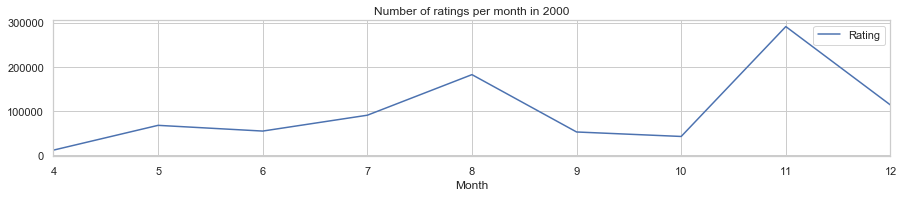

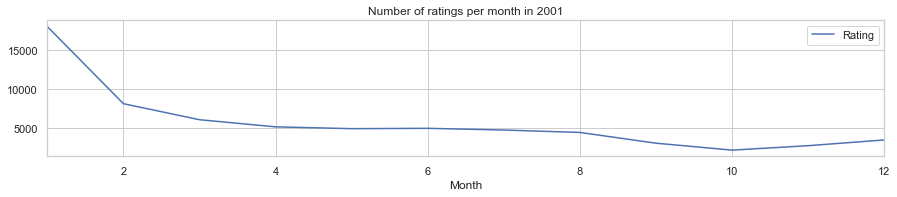

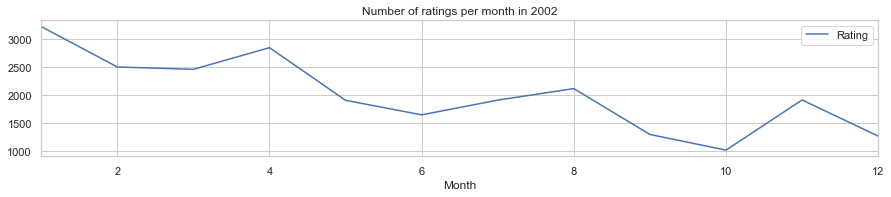

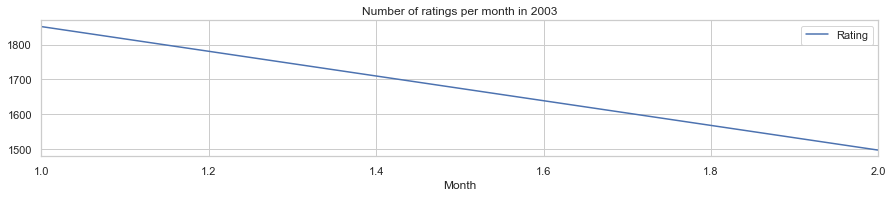

In [187]:
time_rating = all_data_table[['Year', 'Month', 'Rating']].groupby(['Year', 'Month']).count().reset_index()
for year in time_rating['Year'].unique():
    time_rating.loc[time_rating['Year'] == year].plot('Month', 'Rating', title='Number of ratings per month in %s' %year, figsize=(15, 2.5))

The November rating reaches the highest in 2000, but the trend is downward in the rest of years. We can't conclude on the number of ratings pattern because the data ranges from April 2000 to Feb 2003.

#### In conclusion, there is no obvious time effect of the rating score because the rating score is consistent over the year and month. However, we can't conclude on the time effect on the number of rating since we lack some data in 2003.

### Genre Effect Analysis

Let's explore the pattern between genres and rating score.

In [196]:
df_movies.head()

,MovieId,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


From the movies data, the each movie has at least one tag in the Genres column. We firstly seperate them into new columns.

In [201]:
genres_unique = pd.DataFrame(df_movies.Genres.str.split('|').tolist()).stack().unique()
print('Unique genres', genres_unique)
genres_unique = pd.DataFrame(genres_unique, columns=['Genres'])

Unique genres ['Animation' "Children's" 'Comedy' 'Adventure' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Sci-Fi' 'Documentary' 'War'
 'Musical' 'Mystery' 'Film-Noir' 'Western']


There are 18 unique tags. For this categorical data, we use one-hot encoding.

In [204]:
dummy_movies = df_movies.join(df_movies.Genres.str.get_dummies().astype(bool))

In [205]:
dummy_movies.head()

,MovieId,Title,Genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Animation|Children's|Comedy,False,False,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji (1995),Adventure|Children's|Fantasy,False,True,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men (1995),Comedy|Romance,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale (1995),Comedy|Drama,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,Father of the Bride Part II (1995),Comedy,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


Since the tags are pretty similar for each movie, we will only focus on the first tag in the Genres column and group some similiar categories:

* Adventure to Action
* War to Action
* Thriller to Horror
* Sci-Fi to Fantansy

In [262]:
def findGenres(genres):
    for i in range(0, len(genres)):
        if genres[i] == '|':
            return genres[0:i]
        else:
            if i == len(genres) - 1:
                return genres

genres_update = all_data_table['Genres'].apply(lambda x: findGenres(x))
all_data_table['UpdatedGenres'] = genres_update

all_data_table['UpdatedGenres'] = all_data_table['UpdatedGenres'].replace('Adventure', 'Action')
all_data_table['UpdatedGenres'] = all_data_table['UpdatedGenres'].replace('War', 'Action')
all_data_table['UpdatedGenres'] = all_data_table['UpdatedGenres'].replace('Thriller', 'Horror')
all_data_table['UpdatedGenres'] = all_data_table['UpdatedGenres'].replace('Sci-Fi', 'Fantasy')

genres_stats = all_data_table.groupby('UpdatedGenres').agg({'Rating': [np.size, np.mean]})
genres_stats = genres_stats.sort_values([('Rating', 'size')], ascending=False)

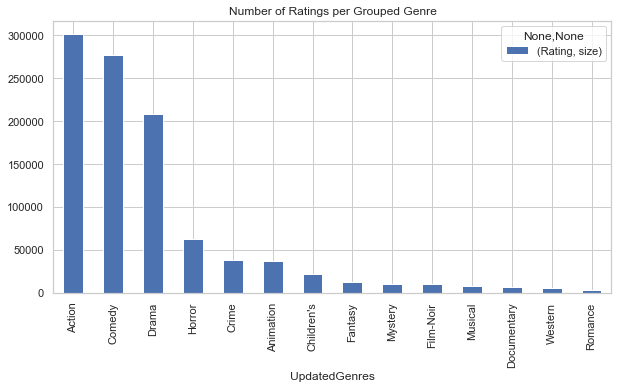

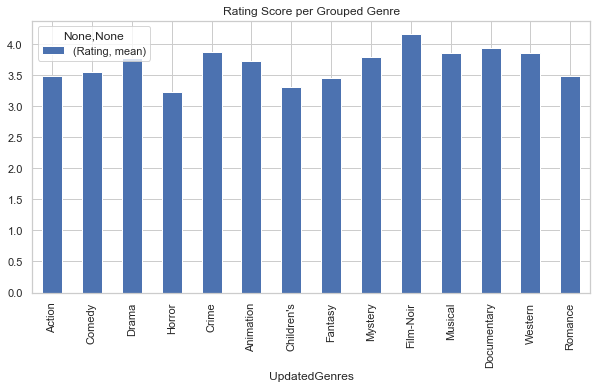

In [263]:
genres_stats = pd.DataFrame(genres_stats)
genres_stats.plot.bar(y=('Rating', 'size'), title='Number of Ratings per Grouped Genre', figsize=(10, 5));
genres_stats.plot.bar(y=('Rating', 'mean'), title='Rating Score per Grouped Genre', figsize=(10, 5));

Although action, comedy and drama are the top three genres people frequently rate, but their average rating score is less than score of documentary, western and romance. Film-Noir has the highest score around 4.5. 

Now let's have a look of the early distribution of rating score and total number of rate.

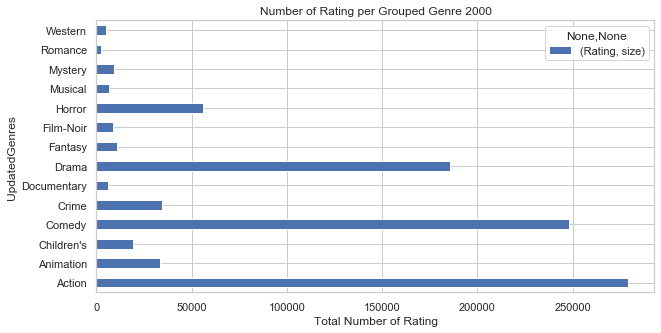

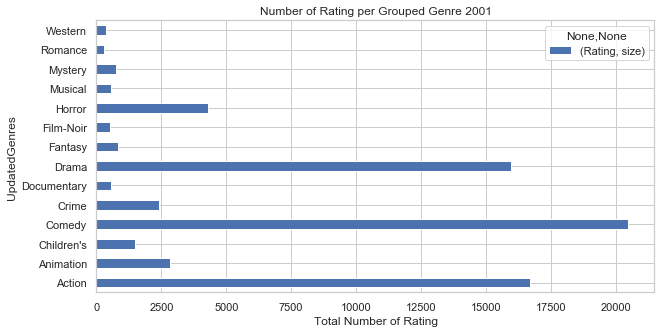

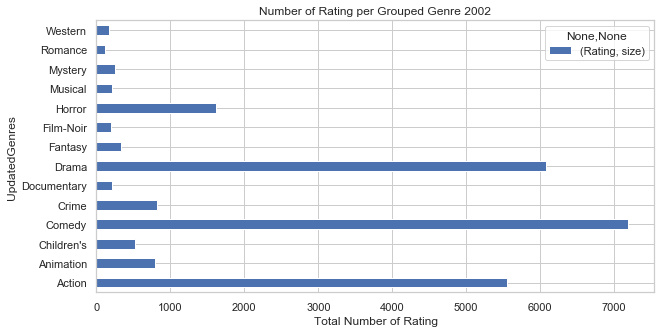

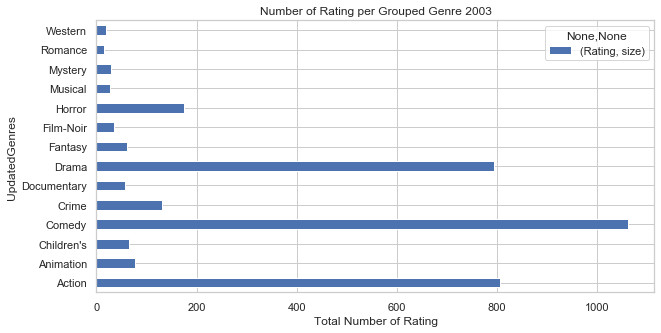

In [269]:
genres_stats = all_data_table[['UpdatedGenres', 'Year', 'Rating']].groupby(['Year', 'UpdatedGenres']).agg({'Rating': [np.size, np.mean]})
year_list = [2000, 2001, 2002, 2003]
for year in year_list:
    temp = genres_stats.loc[year]
    temp.plot.barh(y=('Rating', 'size'), title='Number of Rating per Grouped Genre %s' %year, figsize=(10, 5))
    plt.xlabel('Total Number of Rating')

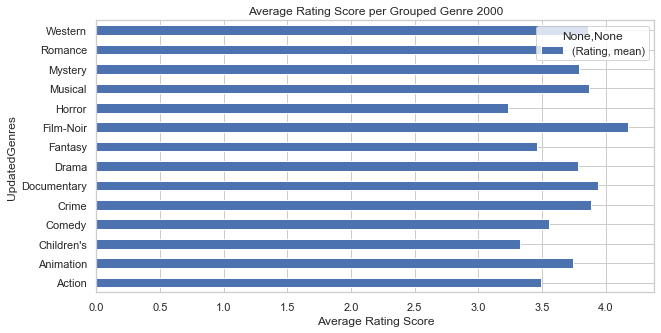

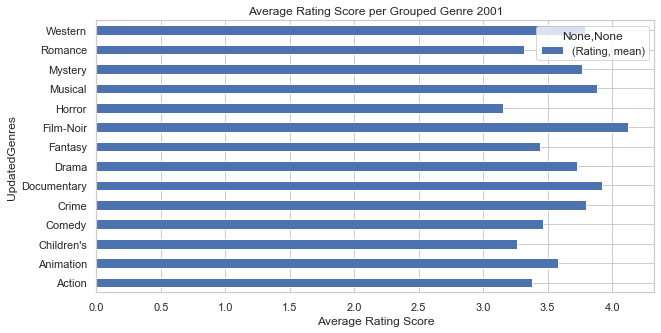

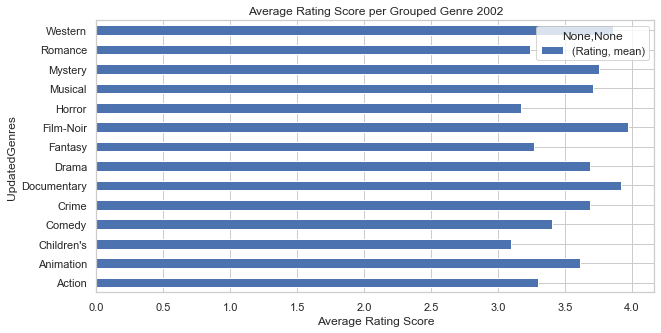

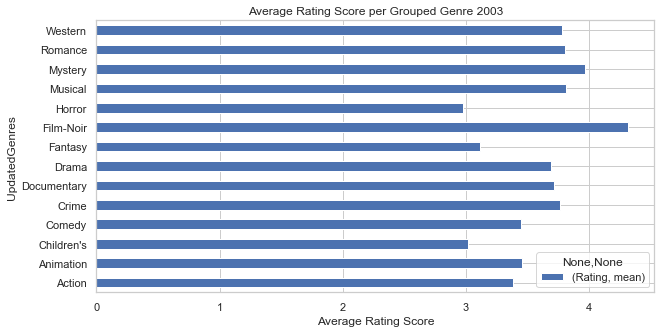

In [270]:
genres_stats = all_data_table[['UpdatedGenres', 'Year', 'Rating']].groupby(['Year', 'UpdatedGenres']).agg({'Rating': [np.size, np.mean]})
year_list = [2000, 2001, 2002, 2003]
for year in year_list:
    temp = genres_stats.loc[year]
    temp.plot.barh(y=('Rating', 'mean'), title='Average Rating Score per Grouped Genre %s' %year, figsize=(10, 5))
    plt.xlabel('Average Rating Score')

The yearly distribution of rating score and total number of rating show the same results as the aggregated average rating score and total rating size.

Then we are going to explore whether user will rate a particular genre higher than the others, showing the preference of movies. We choose the top 4 users who rate the movies more frequently than others do and see how they rate the top 6 genres.

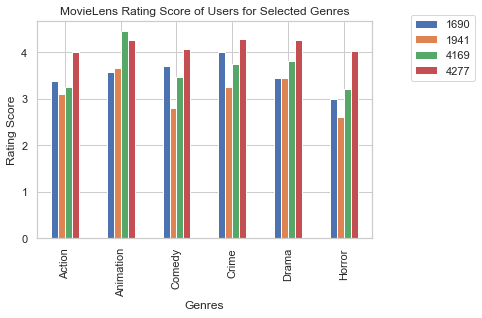

In [273]:
# Filter the table to only include the top 4 UserID and top 6 genres and create a grouped bar chart, with rating as the
# x-axis and UserID as the variable I am grouping on, so there are four bars per genre. 
use_genres_top6 = all_data_table[(all_data_table['UserID'] == 4169) | (all_data_table['UserID'] == 1690)
                                 | (all_data_table['UserID'] == 4277) | (all_data_table['UserID'] == 1941)]

use_genres_top6 = use_genres_top6[
    (use_genres_top6['UpdatedGenres'] == 'Action') | (use_genres_top6['UpdatedGenres'] == 'Comedy')
    | (use_genres_top6['UpdatedGenres'] == 'Drama') | (use_genres_top6['UpdatedGenres'] == 'Horror')
    | (use_genres_top6['UpdatedGenres'] == 'Crime') | (use_genres_top6['UpdatedGenres'] == 'Animation')]

genres_pivot_table = use_genres_top6.pivot_table(index=['UpdatedGenres'],
                                                 columns=['UserID'],
                                                 values='Rating',
                                                 fill_value=0)
genres_pivot_table.plot(kind='bar')
plt.title("MovieLens Rating Score of Users for Selected Genres")
plt.ylabel('Rating Score')
plt.xlabel('Genres')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

Interestingly, every user ranks a particular genre higher than the rest. For example, the highest rating score of user id 4169 is around 4.8 for animation but the highest rating score of user id 1690 is around 4 for crime genres. Users are diverse in their taste and preference but they do have a preference for a particular or a few genre(s).

#### To sum up, there is a genre effect on the average rating score. People do have a preference of a genre to another by ranking the movies in the genre higher than others. Also, the top three genres with most rating and higest rating scores are consistent over years.

### Gender Effect Analysis

Now let's explore whether different gender will have different tastes in movies.

In [297]:
gender_stats = all_data_table.groupby('Gender').agg({'Rating': [np.size, np.mean]})
print(gender_stats.head())

        Rating          
          size      mean
Gender                  
F       246440  3.620366
M       753769  3.568879


Males will rate more movies than females do but females generally will give higher rating scores. Now we want to know whether males and females prefer specific genres over others.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  This is separate from the ipykernel package so we can avoid doing imports until


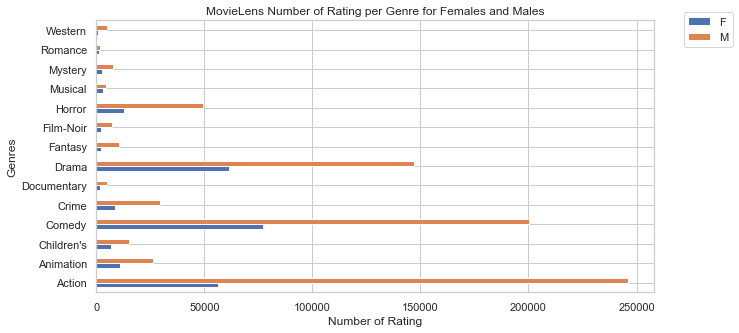

In [324]:
gender_temp = all_data_table[['Gender', 'Rating', 'UpdatedGenres']]

gender_temp = gender_temp.groupby(['Gender', 'UpdatedGenres'])['Rating'].agg({'Rating': np.size})
gender_pivot_table = gender_temp.pivot_table(index=['UpdatedGenres'],
                                                 columns=['Gender'],
                                                 values='Rating',
                                                 fill_value=0)

gender_pivot_table.plot(kind='barh', figsize=(10, 5))
plt.title("MovieLens Number of Rating per Genre for Females and Males")
plt.ylabel('Genres')
plt.xlabel('Number of Rating')
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.show()

The action, comedy, drama and horror genres received most of the ratings and males give more rating to action and females give more rating to comedy. However, in general, male's and female's top four favorite genres are the same. 

Now let's see the average rating score of each genre seperated by genders.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  This is separate from the ipykernel package so we can avoid doing imports until


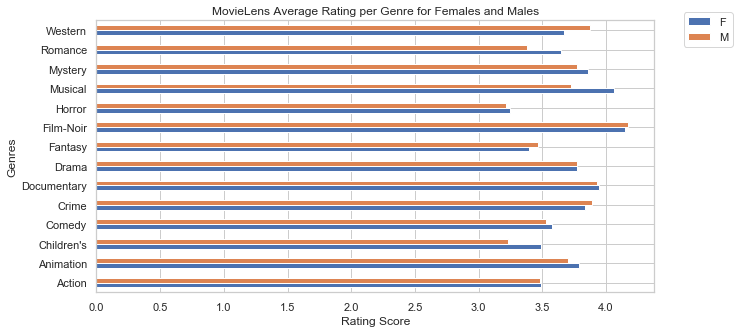

In [337]:
gender_temp = all_data_table[['Gender', 'Rating', 'UpdatedGenres']]

gender_temp = gender_temp.groupby(['Gender', 'UpdatedGenres'])['Rating'].agg({'Rating': np.mean})
gender_pivot_table = gender_temp.pivot_table(index=['UpdatedGenres'],
                                                 columns=['Gender'],
                                                 values='Rating',
                                                 fill_value=0)

gender_pivot_table.plot(kind='barh', figsize=(10, 5))
plt.title("MovieLens Average Rating per Genre for Females and Males")
plt.ylabel('Genres')
plt.xlabel('Rating Score')
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.show()

From the bar graph above, although females rate romance, children and musical a little bit higher than man do, they rate the rest of the movies relatively similar. So we can't say males and females have different taste to the genre but for the three genres mentioned above, females do rate higher than man do.

Now let's take a look of the movies that rate most differently between males and females. There are movies which males rate but females don't, but we can't say females don't like it when the rating score is not available. Thus, we will not consider those circumstances and will focus on the movies which both females and males rate for now.

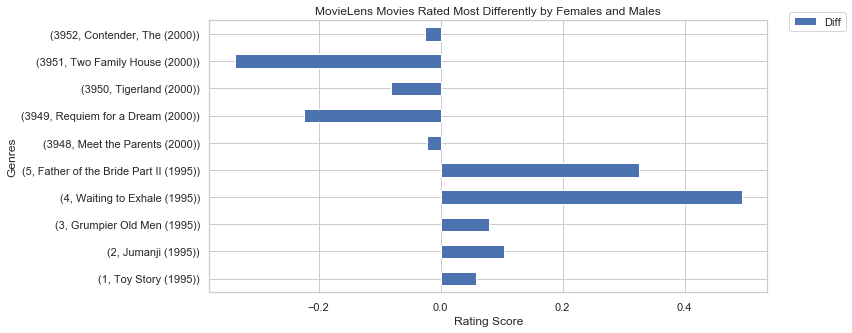

In [368]:
gender_diff_table = all_data_table.pivot_table(index=['MovieId', 'Title'],
                                                columns=['Gender'],
                                                values='Rating')
gender_diff_table = gender_diff_table.dropna()
gender_diff_table['Diff'] = gender_diff_table['F'] - gender_diff_table['M']

diff_top5 = gender_diff_table.head(5)
diff_lowest5 = gender_diff_table.tail(5)

diff_graph = pd.concat([diff_top5, diff_lowest5])
diff_graph.sort_values('Diff', ascending=False)

diff_graph['Diff'].plot(y = 'Title', kind='barh', figsize=(10, 5))
plt.title("MovieLens Movies Rated Most Differently by Females and Males")
plt.ylabel('Genres')
plt.xlabel('Rating Score')
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.show()

In [380]:
# Let's see what the genres that females rate higher than males in the movies rated most differently between genders are
diff_graph2 = pd.concat([diff_top5]).reset_index()
genres_diff = all_data_table[all_data_table['Title'].isin(diff_graph2['Title'])]['UpdatedGenres'].unique()
print(genres_diff)

['Animation' 'Comedy' 'Action']


In the top 5 movies that rated most differently by gender, the genres are animation, comedy and action. Female giving higher scores makes sense when we consider the Toy Story as an example. We do find a difference of rating score in the Children's category in our previous finding and Toy Story definitely fall into both Children and animation categories. 

In [382]:
# Let's see what the genres that males rate higher than females in the movies rated most differently between genders are
diff_graph3 = pd.concat([diff_lowest5]).reset_index()
genres_diff = all_data_table[all_data_table['Title'].isin(diff_graph3['Title'])]['UpdatedGenres'].unique()
print(genres_diff)

['Comedy' 'Drama']


Interestingly, the top movies which man rated higher than females do are from comedy and drama categories. However, in the "MovieLens Average Rating per Genre for Females and Males" graph, the average rating scores of the comedy and drama are pretty similar between man and women.

#### In conclusion, we don't think there is gender effect on the average rating score or the total number of rating because both man and women display similar preferecences to each genre. The most popular genres are action, comedy and drama.

### Age Effect Analysis

Now let's move on to see whether there is an age effect on the average rating score. In the data that MovieLens provided, the age is already grouped in the following ways:

*  1:  "Under 18"
* 18:  "18-24"
* 25:  "25-34"
* 35:  "35-44"
* 45:  "45-49"
* 50:  "50-55"
* 56:  "56+"

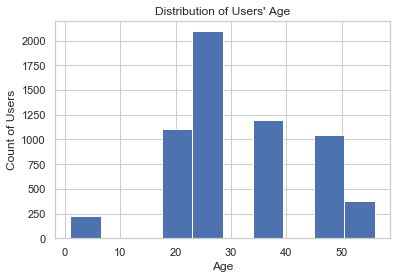

In [385]:
df_users['Age'].hist(bins=10)
plt.title("Distribution of Users' Age")
plt.ylabel('Count of Users')
plt.xlabel('Age')
plt.show()

Most of the user age ranges from 18 to 45, which is 18 years old to 44 years old. Then we want to see the favorite genre to the group ranges from 18 to 45.

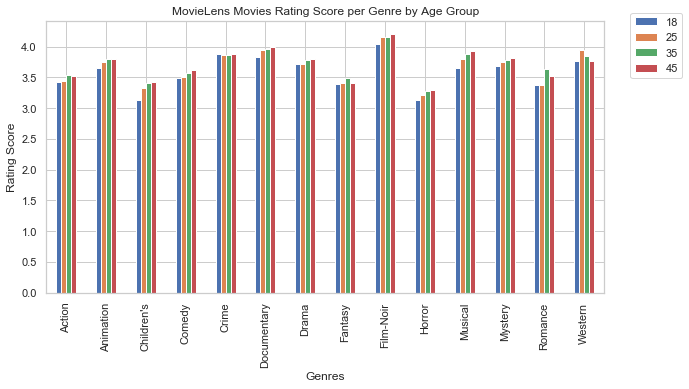

In [408]:
age_list = [18, 25, 35, 45]
age_temp = all_data_table[all_data_table['Age'].isin(age_list)]
age_temp_pivot = age_temp.pivot_table(index=['UpdatedGenres'],
                                                columns=['Age'],
                                                values='Rating')
age_temp_pivot.plot(kind='bar', figsize=(10, 5))
plt.title("MovieLens Movies Rating Score per Genre by Age Group")
plt.ylabel('Rating Score')
plt.xlabel('Genres')
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.show()

We can see that irrespective of the age group, the average review of genre Film-Noir is high. There is an interesting observation that for the under age 18 group(that is for children), the average rating of children's movies is the lowest! Genre Horror is having less than overall average(approximately 3.5) rating across all age group. 

In [429]:
age_stats = all_data_table.groupby('Age').agg({'Rating': [np.size, np.mean]})
print(age_stats)

     Rating          
       size      mean
Age                  
1     27211  3.549520
18   183536  3.507573
25   395556  3.545235
35   199003  3.618162
45    83633  3.638062
50    72490  3.714512
56    38780  3.766632


The older the people are, the higher the score is. The young people are more critical than the elder people.

### Occupation Effect Anlysis

Now let's take a look of the occupation of the users. The below grouping criteria can be found in the read_me document that MovieLens provides:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

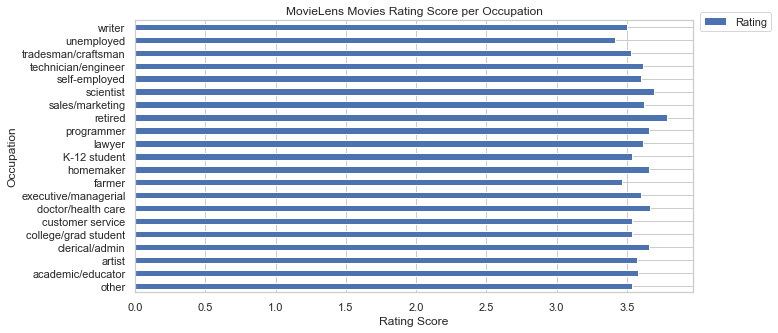

In [452]:
dic = {0:  "other", 1:  "academic/educator", 2:  "artist", 3:  "clerical/admin", 4:  "college/grad student", 5:  "customer service"
, 6:  "doctor/health care", 7:  "executive/managerial", 8:  "farmer", 9:  "homemaker", 10:  "K-12 student", 11:  "lawyer"
, 12:  "programmer", 13:  "retired", 14:  "sales/marketing", 15:  "scientist", 16:  "self-employed", 17:  "technician/engineer"
, 18:  "tradesman/craftsman", 19:  "unemployed", 20:  "writer"}

df_dic = pd.DataFrame(list(dic.items()), columns = ['Occupation', 'Occupation_name'])
age_stats = all_data_table.groupby('Occupation').mean()
temp = age_stats.merge(df_dic, on='Occupation')
temp.plot.barh(x='Occupation_name', y='Rating', title='Average Number of Ratings per Month', figsize=(10, 5))
plt.title("MovieLens Movies Rating Score per Occupation")
plt.ylabel('Occupation')
plt.xlabel('Rating Score')
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.show()

Surpisingly, retired people tend to give slightly higher rating compared to others followed by scientists, clerics, doctors etc. 